## 1.Importing Libraries

In [2]:
import os,json,cv2,numpy as np,matplotlib.pyplot as plt 

import torch 
from torch.utils.data import Dataset,DataLoader 

import torchvision 
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F 

import albumentations as A

In [2]:
import transforms,utils,engine,train 
from utils import collate_fn 
from utils import MetricLogger
from engine import train_one_epoch,evaluate

In [3]:
?DataLoader

## 2.Augmentations

In [3]:
def train_transforms():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1),
            A.HorizontalFlip(p=0.5), 
            A.RandomBrightnessContrast(p=0.3)
        ],p=1)
    ],
    keypoint_params = A.KeypointParams(format='xy'),
    bbox_params = A.BboxParams(format='pascal_voc',label_fields=['bboxes_labels'])
    )

## 3.Dataset Class

In [4]:
class ClassDataset(Dataset):
    def __init__(self,root,transform=None,demo=False):
        self.root = root 
        self.transform = transform 
        self.demo = demo 
        self.imgs_files = sorted(os.listdir(os.path.join(root,"images"))) 
        self.annotations_files = sorted(os.listdir(os.path.join(root,"annotations"))) 

    def __len__(self):
            return len(self.imgs_files)
        
    def unflatten(self,keypoints_original,keypoints_original_flattened): 
        keypoints_transformed_unflattened=[] 
        
        
    def __getitem__(self,idx):
        img_path = os.path.join(self.root,"images",self.imgs_files[idx])
        annotations_path = os.path.join(self.root,"annotations",self.annotations_files[idx]) 
        
        img_original = cv2.imread(img_path) 
        img_original = cv2.cvtColor(img_original,cv2.COLOR_BGR2RGB) 
        
        with open(annotations_path) as f:
            data = json.load(f) 
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints'] 
            #print(keypoints_original)
            bboxes_labels_original = ['mouth' for _ in bboxes_original] 

        if self.transform:
            temp=[el1 for kp in keypoints_original for el in kp for el1 in el if len(el)] 
            keypoints_original_flattened=[None]*len(temp)
            #print("flattened keypoints",keypoints_original_flattened)
            keypoints_original_flattened = [el1 for kp in keypoints_original for el in kp for el1 in el[:2] if len(el)] 
             #print("flattened keypoints",keypoints_original_flattened)
            transformed = self.transform(image=img_original,
                                         bboxes=bboxes_original,
                                         bboxes_labels=bboxes_labels_original,
                                         keypoints=keypoints_original[0])
            img = transformed['image']
            bboxes = transformed['bboxes']
    
            print(transformed['keypoints'])
            #keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']),(-1,2,2)).tolist() 
            keypoints_transformed_unflattened = [[list(t) for t in transformed['keypoints']]]
            keypoints=[] 
            for o_idx,obj in enumerate(keypoints_transformed_unflattened):
                obj_keypoints = [] 
                for k_idx,kp in enumerate(obj):
                    obj_keypoints.append(kp[:2]+[keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints) 
        else:
            img,bboxes,keypoints = img_original,bboxes_original,keypoints_original 

        bboxes = torch.as_tensor(bboxes,dtype=torch.float32) 
        target = {} 
        target["boxes"] = bboxes 
        target["labels"] = torch.as_tensor([1 for _ in bboxes],dtype=torch.int64)
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:,3]-bboxes[:,1])*(bboxes[:,2]-bboxes[:,0])
        target["iscrowd"] = torch.zeros(len(bboxes),dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints,dtype=torch.float32) 
        img = F.to_tensor(img) 

        bboxes_original =torch.as_tensor(bboxes_original,dtype=torch.float32) 
        target_original = {} 
        target_original["boxes"] = bboxes_original 
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original],dtype=torch.int64)
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:,3]-bboxes_original[:,1])*(bboxes_original[:,2]-bboxes[:,0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original),dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original,dtype=torch.float32) 
        img_original = F.to_tensor(img_original) 

        if self.demo:
            return img,target,img_original,target_original 
        else:
            return img,target 
        
        


In [5]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        #img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are glue tubes
            bboxes_labels_original = ['Glue tube' for _ in bboxes_original]            

        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,2,2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are glue tubes
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

## 4.Visualize example

In [6]:
KEYPOINTS_FOLDER_TRAIN ='./train'

In [7]:
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN,transform=train_transforms(),demo=True)

In [8]:
#dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN,demo=True)

In [9]:
data_loader = DataLoader(dataset,batch_size=1,shuffle=True,collate_fn=collate_fn) 
    
iterator = iter(data_loader) 
batch = next(iterator)
print("Original")
print(batch[3])

print("Transformed")
print(batch[1])

Original
({'boxes': tensor([[106., 221., 270., 295.]]), 'labels': tensor([1]), 'image_id': tensor([136]), 'area': tensor([12136.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[182., 285.,   1.],
         [192., 254.,   1.]]])},)
Transformed
({'boxes': tensor([[106., 121., 270., 195.]]), 'labels': tensor([1]), 'image_id': tensor([136]), 'area': tensor([12136.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[182., 130.,   1.],
         [192., 161.,   1.]]])},)


### 4.1

In [10]:
keypoints_classes_ids2names = {0: 'lower', 1: 'upper'}

In [11]:
def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

In [12]:
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

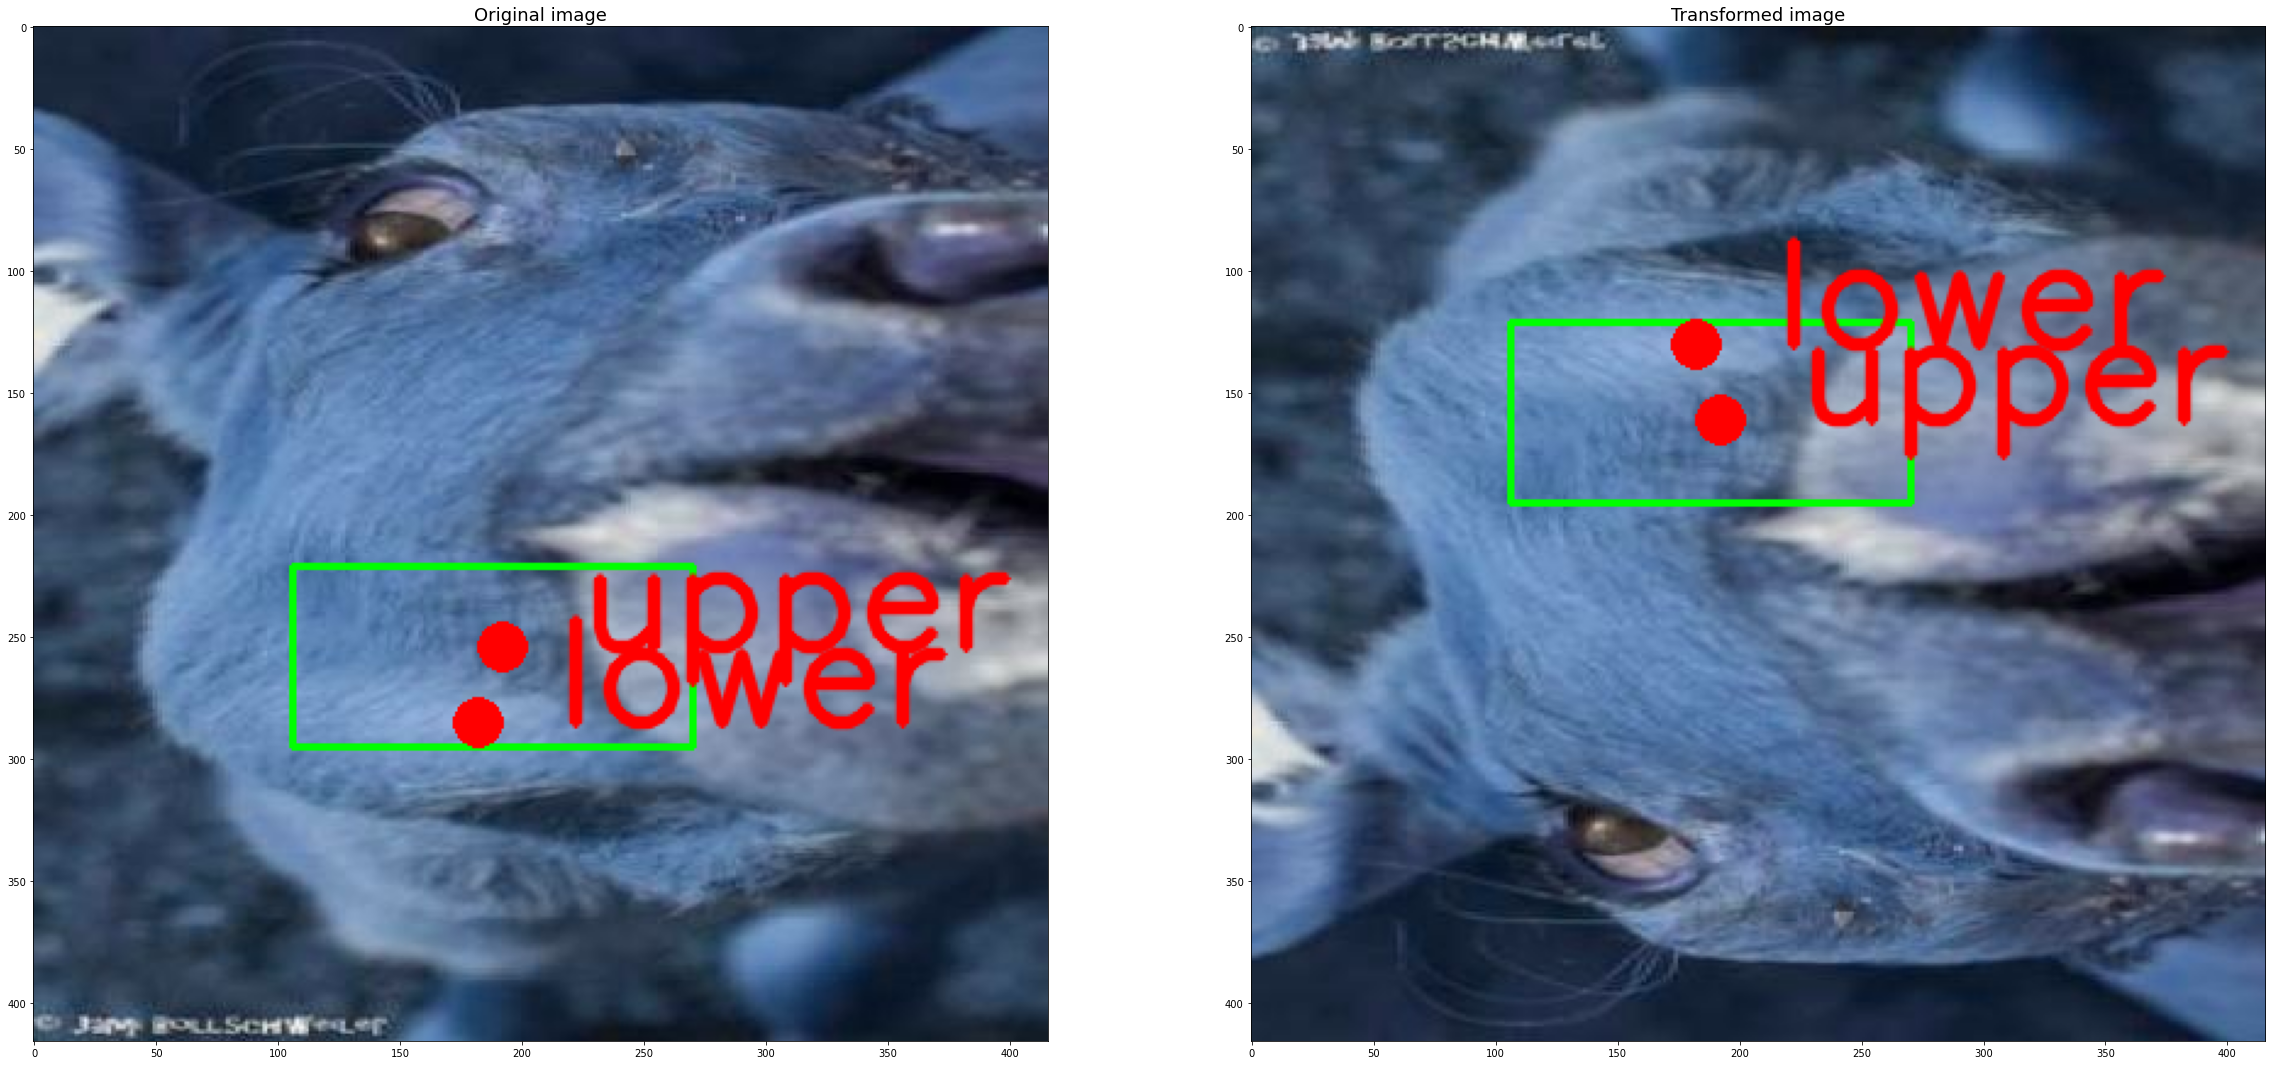

In [13]:
visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

## 5.Training

In [14]:
def get_model(num_keypoints,weights_path=None): 
    
    anchor_generator = AnchorGenerator(sizes=(32,64,128,256,512),aspect_ratios=(0.25,0.5,0.75,1.0,2.0,3.0,4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                  pretrained_backbone=True,
                                                                  num_keypoints=num_keypoints,
                                                                  num_classes=2,
                                                                  rpn_anchor_generator=anchor_generator)
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

KEYPOINTS_FOLDERS_TRAIN ='./train'
KEYPOINTS_FOLDERS_VALID = './valid' 
KEYPOINTS_FOLDERS_TEST = './test'

dataset_train = ClassDataset(KEYPOINTS_FOLDERS_TRAIN, transform = train_transforms(), demo=False) 
dataset_test = ClassDataset(KEYPOINTS_FOLDERS_TEST,demo=False) 
dataset_valid = ClassDataset(KEYPOINTS_FOLDERS_VALID,demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=20, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)
data_loader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [16]:
model = get_model(num_keypoints=2)
model.to(device)

/home/antonobel/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/antonobel/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/antonobel/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  warnings.warn(
/home/antonobel/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and will be removed in 0.15. The current be

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

In [17]:
params =[p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,lr=0.001,momentum=0.9,weight_decay=0.0005)

In [18]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.3)

In [19]:
num_epochs=10
metriclog = None

In [20]:
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
    lr_scheduler.step() 
    evaluate(model,data_loader_test,device) 


IndexError: list index out of range

In [ ]:
#torch.save(model.state_dict(),'./')

In [ ]:
iterator = iter(data_loader_test)
images, targets = next(iterator)
images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

print("Predictions: \n", output)

In [ ]:

image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.5)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])
    

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image, bboxes, keypoints)